In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PyCO2SYS as pyco2
import cartopy.crs as ccrs

df = pd.read_csv("../../compilation/data/in_situ_rates_compiled_allvar.csv")

In [5]:
def makemap(dataframe):    
    recent_stations_lat = []
    recent_stations_lon = []
    

    for cruise in dataframe['G2expocode'].unique():
        glodap22_cruise = dataframe[dataframe['G2expocode'] == cruise]
        for station in glodap22_cruise['G2station'].unique():
            glodap22_cruise_station = glodap22_cruise[glodap22_cruise['G2station'] == station]

            recent_stations_lat.append(glodap22_cruise_station['G2latitude'].values[0])
            recent_stations_lon.append(glodap22_cruise_station['G2longitude'].values[0])

    plt.figure(dpi=200)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()
    gl = ax.gridlines(draw_labels=True)
    plt.scatter(recent_stations_lon, recent_stations_lat, color='red', s=0.1)
    plt.scatter(df['Longitude'].unique(), df['Latitude'].unique(), color='blue', s=5)
    #gl = ax.gridlines(draw_labels=True)
    gl.xlabel_style = {'size': 5, 'color': 'gray'}
    gl.ylabel_style = {'size': 5, 'color': 'gray'}
    plt.show()

## Make validation dataset

In [6]:
path_gp="/Users/ben/Dropbox/PhD/GLODAP/"
df_glodap = pd.read_csv(path_gp+'GLODAPv2.2022_Merged_Master_File.csv',  na_values=-9999)

# columns I care about
col = ['G2expocode', 'G2station', 'G2maxsampdepth', 'G2cast', 'G2year', 'G2month', 'G2longitude', 'G2latitude', 
       'G2pressure', 'G2depth', 'G2temperature', 'G2salinity', 'G2oxygen', 
       'G2nitrate', 'G2silicate', 'G2phosphate',
       'G2talk', 'G2tco2', 'G2phtsinsitutp']

# only relevant columns that are also complete with info (have TA, DIC, pH)
glodap22 = df_glodap[col].dropna(axis=0)

# only cruises data from past 2016
glodap22_recent = glodap22[glodap22['G2year'] > 2016]

# stations with at least 1500 m sampling depth)
g22_recent = glodap22_recent[glodap22_recent.G2maxsampdepth > 1000].reset_index(drop=True)


g22_recent.shape

/var/folders/38/38dzbjpx6nz16p7v6rzy9yvw0000gn/T/ipykernel_50061/4064897988.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_glodap = pd.read_csv(path_gp+'GLODAPv2.2022_Merged_Master_File.csv',  na_values=-9999)


(41636, 19)

## Plot cruises that have not been used when training CANYON-B (past 2016)

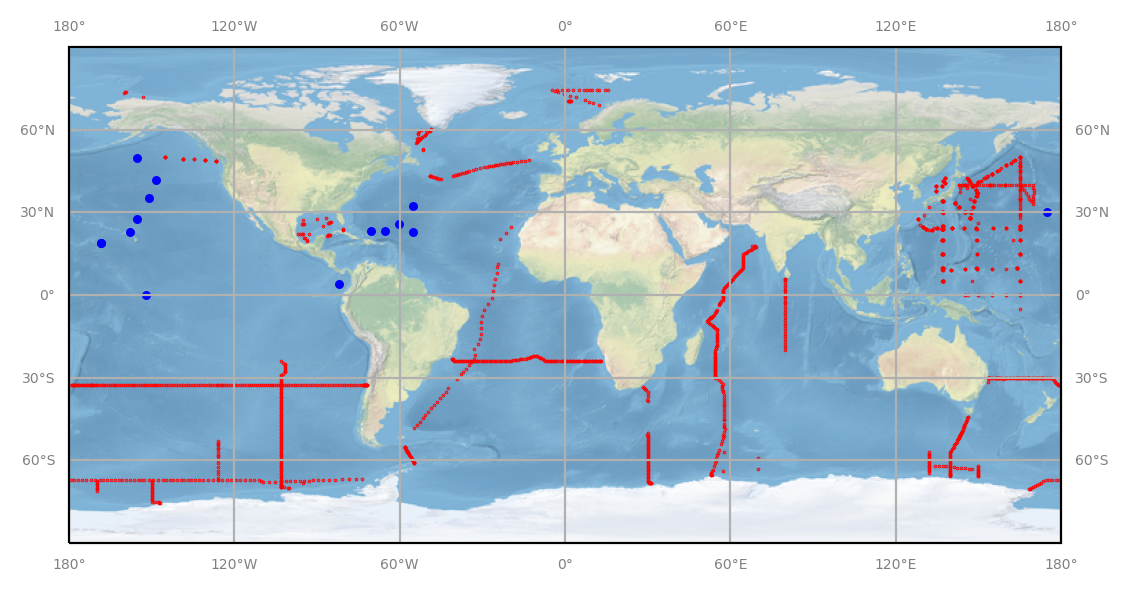

In [7]:
makemap(g22_recent)

# Add WOA data

In [8]:
from scipy.interpolate import PchipInterpolator
import xarray as xr
import gsw

with open('../../woa18/path-to-woa18-files.txt') as f:
    path_woa = f.readline()

seasons = {}
for m in [1,2,3]: seasons[m] = '13'
for m in [4,5,6]: seasons[m] = '14'
for m in [7,8,9]: seasons[m] = '15'
for m in [10,11,12]: seasons[m] = '16'
    
depths = np.array([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,125,150,175,200,225,250,275,300,325,350,
       375,400,425,450,475,500,550,600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,
       1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,
       3000,3100,3200,3300,3400,3500,3600,3700,3800,3900,4000,4100,4200,4300,4400,4500,4600,4700,4800,4900,
       5000,5100,5200,5300,5400,5500])
    


In [9]:
def import_var_an(var, lat, lon, seas):
    # import annual (y) and seasonal (s) data
    try:
        if (var == 't') or (var == 's'):
            var_y = xr.open_dataset(path_woa+"woa18_decav_"+var+"00_01.nc", decode_times=False).isel(time=0, drop=True)
            var_s = xr.open_dataset(path_woa+"woa18_decav_"+var+seas+"_01.nc", decode_times=False).isel(time=0, drop=True)
        else:
            var_y = xr.open_dataset(path_woa+"woa18_all_"+var+"00_01.nc", decode_times=False).isel(time=0, drop=True)
            var_s = xr.open_dataset(path_woa+"woa18_all_"+var+seas+"_01.nc", decode_times=False).isel(time=0, drop=True)
    except:
        print(var, 'file is missing')

    # find location of measurement site:
    var_y_loc = var_y.sel(lat=lat, lon=lon, method="nearest", tolerance=0.5)
    var_s_loc = var_s.sel(lat=lat, lon=lon, method="nearest", tolerance=0.5)
    
    # get arrays (annual average (an), standard deviation (sd), number of observations (dd))
    # upper 800 (43 levels) from seasonal (if season not known, then it's just the annual data anyway)
    # everything below is from annual data
    if (var == 'p') or (var == 'i'):
        var_an = np.append(var_s_loc[var+'_an'].values[0:43], var_y_loc[var+'_an'].values[43:])
    else:
        var_an = np.append(var_s_loc[var+'_an'].values[0:57], var_y_loc[var+'_an'].values[57:])
        
    return var_an


def get_interpolators(var, lat, lon, seas, datatype='an'):        
    var_arr = import_var_an(var, lat, lon, seas)
     
    try:
        if np.count_nonzero(np.isnan(var_arr)) > 0:
            var_interp = PchipInterpolator(depths[:-np.count_nonzero(np.isnan(var_arr))], 
                                   var_arr[:-np.count_nonzero(np.isnan(var_arr))], 
                                   extrapolate=False)        
        else:
            var_interp = PchipInterpolator(depths, var_arr, extrapolate=False)
    except:
        print("can't interpolate")
    
    return var_interp

In [10]:
#for cruise in g22_recent['G2expocode'].unique():
for cruise in g22_recent['G2expocode'].unique():
    print(cruise)
    g22_recent_cruise = g22_recent[g22_recent['G2expocode'] == cruise]
    for station in g22_recent_cruise['G2station'].unique():   
        
        cruisestation = (g22_recent["G2expocode"] == cruise) & (g22_recent["G2station"] == station)
        
        lat = g22_recent[cruisestation]['G2latitude'].values[0]
        lon = g22_recent[cruisestation]['G2longitude'].values[0]
        
        seas = seasons[g22_recent[cruisestation]['G2month'].values[0]]
        
        #print(g22_recent[cruisestation]['G2depth'].max())
        
        try:
            t_interp = get_interpolators('t', lat, lon, seas)
            g22_recent.loc[(cruisestation),["Temp_WOA"]] = t_interp(g22_recent[cruisestation]['G2depth'])

            s_interp = get_interpolators('s', lat, lon, seas)                
            g22_recent.loc[(cruisestation),["Sal_WOA"]] = s_interp(g22_recent[cruisestation]['G2depth'])        

            o_interp = get_interpolators('o', lat, lon, seas)                
            g22_recent.loc[(cruisestation),["Doxy_WOA"]] = o_interp(g22_recent[cruisestation]['G2depth'])

            p_interp = get_interpolators('p', lat, lon, seas)                
            g22_recent.loc[(cruisestation),["PO4_WOA"]] = p_interp(g22_recent[cruisestation]['G2depth'])

            i_interp = get_interpolators('i', lat, lon, seas)                
            g22_recent.loc[(cruisestation),["SiOH4_WOA"]] = i_interp(g22_recent[cruisestation]['G2depth'])
        except:
            g22_recent.loc[(cruisestation),["Temp_WOA", "Sal_WOA", 'Doxy_WOA', 'PO4_WOA', 'SiOH4_WOA']] = np.nan 
            

33RO20161119
49NZ20170208
096U20180111
29HE20190406
45CE20170427
49UF20170110
49UF20170228
49UF20170408
49UF20170502
49UF20170612
49UF20170719
can't interpolate
49UF20171107
49UF20180129
49UF20180406
49UF20180518
49UF20180709
49UF20180927
49UP20170107
49UP20170201
49UP20170425
49UP20170623
49UP20170815
49UP20171125
49UP20180110
49UP20180228
49UP20180501
49UP20180614
740H20180228
91AA20171209
18DD20170205
18DD20170604
18DD20190205
18DD20190602
320620170703
can't interpolate
can't interpolate
can't interpolate
can't interpolate
can't interpolate
can't interpolate
can't interpolate
320620170820
320620170820
can't interpolate
can't interpolate
320620180309
can't interpolate
can't interpolate
can't interpolate
325020190403
325020190403
33RO20180423
49NZ20191229
58JH20190515
74JC20181103
18DL20200722
33HQ20170826
33HQ20180807
33HQ20190806
33RO20170718
can't interpolate
can't interpolate
49NZ20191205
49UF20190207
49UF20190716
can't interpolate
49UF20190916
49UF20200108
49UF20200201
49UF202006

In [11]:
print(g22_recent['G2depth'].count())
print(g22_recent['Temp_WOA'].count())

41636
39943


In [12]:
# remove where no data
g22_recent = g22_recent.dropna(axis=0)

# save dataset
g22_recent.to_csv("data/glodap22_recent_withWOA.csv", index=False)

# save with the stuff I need to do CANYON-B
g22_recent_canyonb = g22_recent[["G2latitude", "G2longitude", "G2depth", "G2pressure", 
                 "Temp_WOA", "Sal_WOA", "Doxy_WOA", "G2year", "G2month"]].copy()
g22_recent_canyonb.to_csv("data/glodap22_recent_withWOA_forCANYONB.csv", header=False, index=False)